# Description

Telecom is as telecommunications company which offers cellular phone and internet services. They have had some issues with customer retention and would like to see if there is way to improve their detection of customers who are at risk of terminating their service. 

# Problem

My goal is to build a machine learning algorith that will detect the likelihood that certain customers are at risk of leaving telecoms service. I will perform exploratory data analysis to gather a better understanding of the features in the data. I will then experiment with a few different ML models to see which one, if any, is sufficient in predicting user behavior.

# Table of Contents <a id='back'> </a>

* [1 Load and Preprocessing Data](#load) 
* [2 Exploratory Data Analysis](#eda) 
* [3 Feature Splitting and Engineering](#features)
* [4 Model Creation and Evaluation](#model)
* [5 Final Model Evaluation](#final)
* [6 Report](#report) 

## 1 Load and Preprocessing Data<a id = 'load'></a>

In [145]:
# importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta
import datetime

In [146]:
# reading data to variables

contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

### Contract Database

In [147]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [148]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [149]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [150]:
total_departed = len(contract[contract['EndDate'] != 'No']) / len(contract)
print(f'Total number of customers who have left Telecom: {total_departed * 100:.2f}%')

Total number of customers who have left Telecom: 26.54%


Preprocessing Tasks for contract database:
    
    -change BeginDate column to datetime 
    -change TotalCharges column to float 
    -convert all columns to lowercase
    

Feature Engineering for Contract Database:

    -create column of binary values for those who have left the service and those that have not
    -one hot encode for all categorical features 
    -perform class balancing 
    -look at seasonality for the Begin Date column

Create a target column of binary values to represent those who have left and those who have not. 

In [151]:
# lowercasing and renaming column names 
contract.columns = contract.columns.str.lower()
contract = contract.rename(columns = {'customerid': 'customer_id',
                          'begindate': 'begin_date',
                          'enddate': 'end_date',
                          'paperlessbilling': 'paperless_billing',
                          'paymentmethod': 'payment_method',
                          'monthlycharges': 'monthly_charges',
                          'totalcharges': 'total_charges'})

In [152]:
# when looking to change datatypes, I ran into a small group of guests that did not have a total_charges value,
# as they were new to the database. Given our task, I felt it safe to drop them from the dataset
no_total = contract[contract['total_charges'] == ' '].index
contract.drop(no_total, inplace = True)
contract.reset_index(inplace = True, drop = True)

In [153]:
# changing data types
contract['total_charges'] = contract['total_charges'].astype('float')
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format = '%Y-%m-%d')

In [154]:
# checking to ensure data types are the correct type
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 439.6+ KB


In [155]:
# creating function to find missing and duplicated values for all databases
def find_missing_dup(data):
    print('Number of missing values:')
    print(data.isna().sum())
    print(f'Total duplicates: {data.duplicated().sum()}')
    con_dup = data['customer_id'].duplicated().sum()
    print(f'Number of duplicates in customer_id column: {con_dup}')

In [156]:
# checking for missing and duplicate values
find_missing_dup(contract)

Number of missing values:
customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64
Total duplicates: 0
Number of duplicates in customer_id column: 0


In [157]:
no_total

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [158]:
# adding in target feature for future data analysis
departed = []
for value in contract['end_date']:
    if value != 'No':
        departed.append('terminated')
    else:
        departed.append('active')
    
contract['service_status'] = departed

# Internet database

In [159]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [160]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [161]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

At first glance, we have less observations in the internet database as compared to the contract database. Data could be missing for those who have left the service, or perhaps there are those who just do not have the internet service. Either way, this will need to be addressed when the databases are joined.

Preprocessing steps for internet database:

    -make all columns lowercase
   

Feature Engineering for internet databse:
    
    - one hot encoding

In [162]:
# lowercasing and renaming columns 
internet.columns = internet.columns.str.lower()
internet = internet.rename(columns = {'customerid': 'customer_id',
                          'internetservice': 'internet_service',
                          'onlinesecurity': 'online_security',
                          'onlinebackup': 'online_backup',
                          'deviceprotection': 'device_protection',
                          'techsupport': 'tech_support',
                          'streamingtv': 'streaming_tv',
                           'streamingmovies': 'streaming_movies'})
internet.head(5)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [163]:
# looking at those who have departed the service

ids_departed = contract[contract['end_date'] != 'No']['customer_id']
print(len(ids_departed))
internet[internet['customer_id'].isin(ids_departed)]

1869


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
12,0280-XJGEX,Fiber optic,No,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...
5497,1699-HPSBG,DSL,No,No,No,Yes,Yes,No
5502,8775-CEBBJ,DSL,No,No,No,No,No,No
5507,6894-LFHLY,Fiber optic,No,No,No,No,No,No
5509,0639-TSIQW,Fiber optic,Yes,Yes,Yes,No,Yes,No


To answer my question from above, we do have internet data for those that have left the program. So we are missing internet data for roughly 1500 people. I will look into this in the following blocks.

In [164]:
# looking at the obsservations that do not have any internet data
contract[contract['customer_id'].isin(internet['customer_id']) == False]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,service_status
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,active
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,active
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,active
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,terminated
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20,active
...,...,...,...,...,...,...,...,...,...
7006,4807-IZYOZ,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75,active
7008,9710-NJERN,2016-11-01,No,Two year,No,Mailed check,20.15,826.00,active
7009,9837-FWLCH,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,239.00,active
7019,0871-OPBXW,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25,active


No consistencies in the data where internet data is absent. Will fill these values accordingly when the data is merged to 'unknown'. 

In [165]:
# checking for missing and duplicate values
find_missing_dup(internet)

Number of missing values:
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64
Total duplicates: 0
Number of duplicates in customer_id column: 0


# Personal Database

In [166]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [167]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Preprocessing steps for the personal Database:
    
    - make all columns lowercase
    - change SeniorCitizen data type to object 


Feature Engineering tasks for personal database:

    -one hot encoding

In [168]:
# lowercasing and renaming the columns
personal.columns = personal.columns.str.lower()
personal = personal.rename(columns = {'customerid': 'customer_id',
                                      'seniorcitizen': 'senior_citizen'
})


In [169]:
# dropping same rows that I did from the contract databse 
personal.drop(no_total, inplace = True)
personal.reset_index(inplace = True, drop = True)


In [170]:
# checking for missing and duplicate values
find_missing_dup(personal)

Number of missing values:
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
Total duplicates: 0
Number of duplicates in customer_id column: 0


# Phone Database

In [171]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [172]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Preprocessing tasks for phone database: 
    
    - lowercase column names

Feature Engineering tasks for phone database: 

    -change binary values from yes/no to 1/0 

In [173]:
# lowercasing and renaming columns
phone.columns = phone.columns.str.lower()
phone = phone.rename(columns = {'customerid': 'customer_id',
                               'multiplelines': 'multiple_lines'})

In [174]:
# looking to see if there are any consistencies in the customer ids that do not have phone data; no pattern seen
# will fill these values with 'unknown' when the datasets are merged 
contract[contract['customer_id'].isin(phone['customer_id']) == False]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,service_status
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,active
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,active
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,active
20,8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65,terminated
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20,terminated
...,...,...,...,...,...,...,...,...,...
6992,4501-VCPFK,2017-12-01,No,Month-to-month,No,Electronic check,35.75,1022.50,active
6996,2274-XUATA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),63.10,4685.55,active
7018,2235-DWLJU,2019-08-01,No,Month-to-month,Yes,Electronic check,44.40,263.05,active
7025,7750-EYXWZ,2019-02-01,No,One year,No,Electronic check,60.65,743.30,active


# 2 Exploratory Data Analysis <a id = 'eda'></a>

In [175]:
# creating date time object to subtract other values from
time = pd.to_datetime('2020-02-01', format = '%Y-%m-%d')

In [176]:
# creating list of values to look at length of time with the service per client
date_diff = []
for i in range(len(contract)):
    if contract['end_date'][i] == 'No':
        date_diff.append((time - contract['begin_date'][i]))
    else:
        contract['end_date'][i] = pd.to_datetime(contract['end_date'][i], format = '%Y-%m-%d')
        date_diff.append(contract['end_date'][i] - contract['begin_date'][i])

/var/folders/41/r7v088h101110hk6h74712800000gn/T/ipykernel_4540/2509307836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract['end_date'][i] = pd.to_datetime(contract['end_date'][i], format = '%Y-%m-%d')


In [177]:
# establishing days_active column
contract['days_active'] = date_diff
contract['days_active'] = contract['days_active'].dt.days

In [178]:
# merging datasets before performing EDA 
df_full = contract.merge(personal, on = 'customer_id', how = 'outer')
df_full = df_full.merge(internet, on = 'customer_id', how = 'outer')
df_full = df_full.merge(phone, how = 'outer', on = 'customer_id')

In [179]:
to_drop = df_full.tail(11).index
df_full.drop(to_drop, inplace = True)

In [180]:
# addressing missing values from customers who do not have internet or phone data; filling these null values 
# with the string 'None'
df_full.fillna('None', inplace = True)

In [181]:
# creating Yes/No list of senior citizen status 
df_full['senior_citizen'] = ['Yes' if age == 1 else 'No' for age in df_full['senior_citizen']]

In [182]:
# data has been successfully merged
df_full.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,service_status,days_active,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,active,31.0,...,Yes,No,DSL,No,Yes,No,No,No,No,None
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,active,1036.0,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,terminated,61.0,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,active,1371.0,...,No,No,DSL,Yes,No,Yes,Yes,No,No,None
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,terminated,61.0,...,No,No,Fiber optic,No,No,No,No,No,No,No


## Univariate Analysis

In [183]:
#  looking at the distribution of numerical values in the dataset 
df_full[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


Text(0.5, 1.0, 'KDE of Monthly Charges')

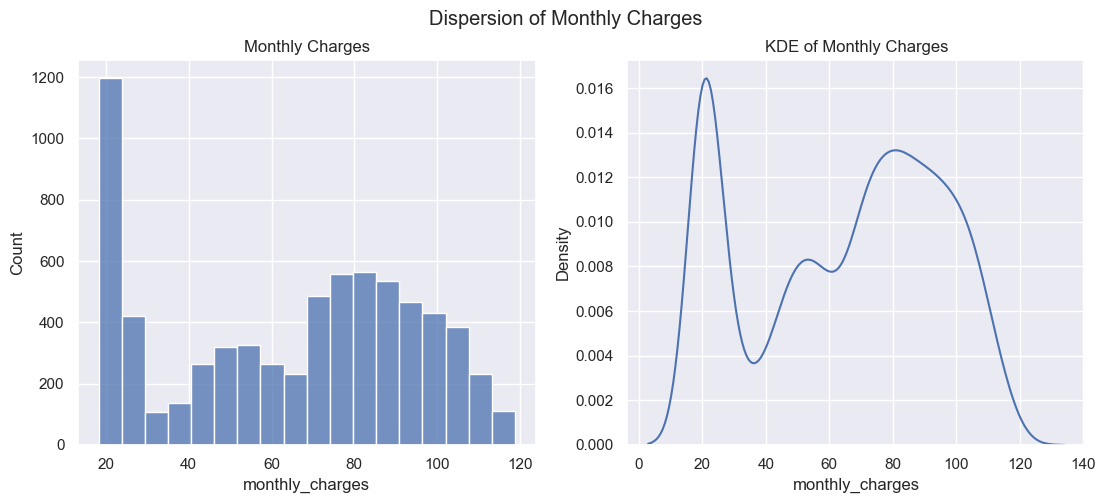

In [184]:
# looking at dispersion of monthly charges for each customer
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

fig.suptitle('Dispersion of Monthly Charges')

sns.histplot(df_full, x = 'monthly_charges', ax = axes[0])
axes[0].set_title('Monthly Charges')

sns.kdeplot(df_full, x = 'monthly_charges', ax = axes[1])
axes[1].set_title('KDE of Monthly Charges')

Monthly charges show that there are a high concentration of those that are within the 20-30 range. There are two crests in the data, potentially showing two different monthly patterns with a crest around the 50 monthly charge value and another crest around the 80-85 monthly charge value. This could indicate two separate user segments. 

Text(0.5, 1.0, 'KDE of Total Charges')

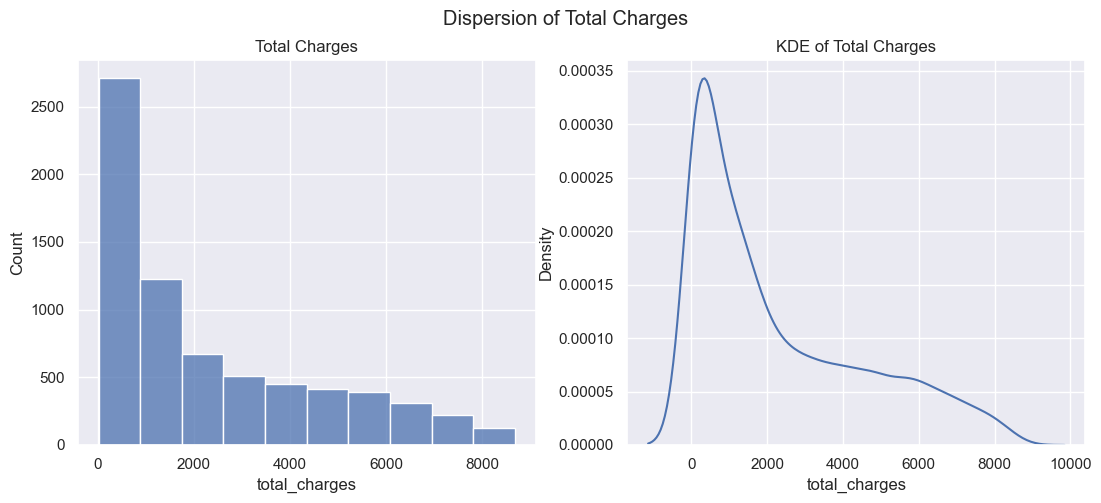

In [185]:
# looking at dispersion of total charges for each customer
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

fig.suptitle('Dispersion of Total Charges')

sns.histplot(df_full, x = 'total_charges', ax = axes[0], bins = 10)
axes[0].set_title('Total Charges')

sns.kdeplot(df_full, x = 'total_charges', ax = axes[1])
axes[1].set_title('KDE of Total Charges')

The dispersion of total charges shows a strong positive skew, with the mode occuring in the 0 - 1000 range. While a majoiry of users tend to spend within this range, we do have a significant number of users that have spent more money. 

Text(0.5, 1.0, 'KDE of Total Days Active')

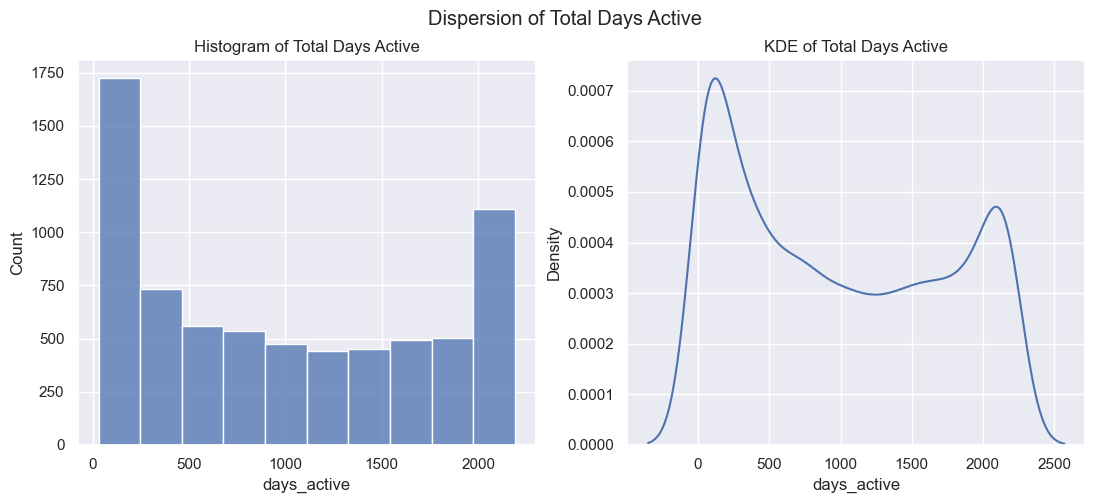

In [186]:
# looking at dispersion for total days active for each customer 
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

fig.suptitle('Dispersion of Total Days Active')

sns.histplot(df_full, x = 'days_active', ax = axes[0], bins = 10)
axes[0].set_title('Histogram of Total Days Active')

sns.kdeplot(df_full, x = 'days_active', ax = axes[1])
axes[1].set_title('KDE of Total Days Active')

The dispersion of total days active for customers is bi-modal, with a majority of values from approx. 0-250 and from 2000+. 

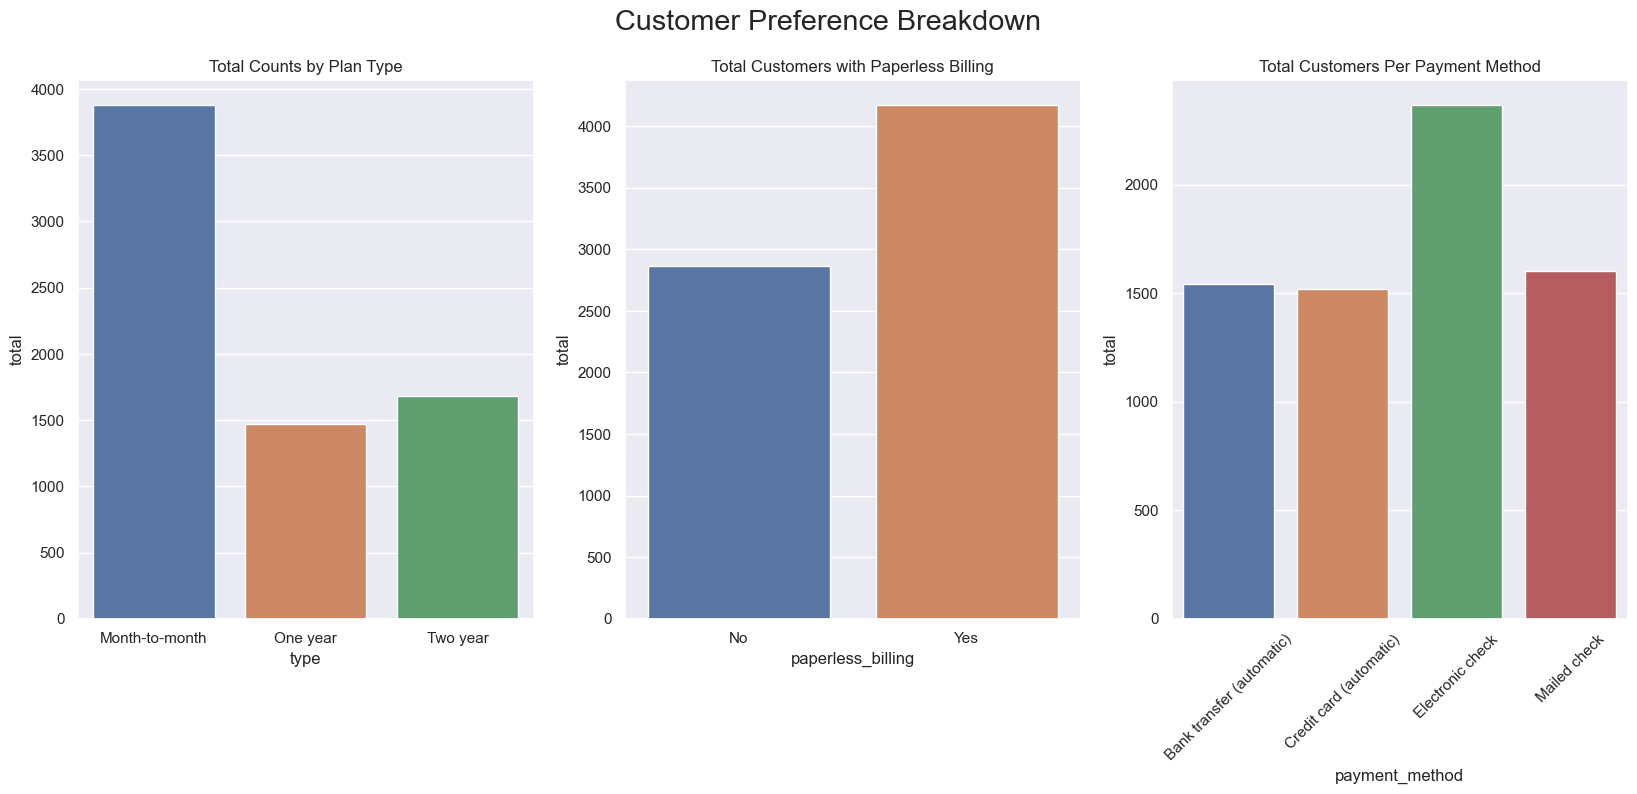

In [187]:
#  creating graphical layout for contract data breakdown

fig1, axes = plt.subplots(1, 3, figsize = (20, 7))
fig1.suptitle('Customer Preference Breakdown', fontsize = 'xx-large')

type_total = df_full.groupby('type').agg({'type': 'count'}).rename(columns = {'type': 'total'})
sns.barplot(type_total, x = type_total.index, y = 'total',ax = axes[0])
axes[0].set_title('Total Counts by Plan Type')

paperless_total = df_full.groupby('paperless_billing').agg({'paperless_billing': 'count'}).rename(columns = {'paperless_billing': 'total'})
sns.barplot(paperless_total, x = paperless_total.index, y = 'total', ax = axes[1])
axes[1].set_title('Total Customers with Paperless Billing')


payment_total = df_full.groupby('payment_method').agg({'payment_method': 'count'}).rename(columns = {'payment_method': 'total'})
sns.barplot(payment_total, x = payment_total.index, y = 'total', ax = axes[2])
axes[2].set_title('Total Customers Per Payment Method')
axes[2].tick_params(axis='x', rotation=45)




A few insights can be derived from the three charts above: 

    - a majority of customers are currenlty subscribed to the month-to-month plan
    - the one year plan is the least popular amongst the options 
    - customers of Telecom prefer paperless billing, signaling a preference for digital interactions 
    - E-check is the most popular method of payment for Telecom's customer base, with no distinct differences amongst the remaining three options 

Text(0.5, 1.0, 'Customers with Dependents')

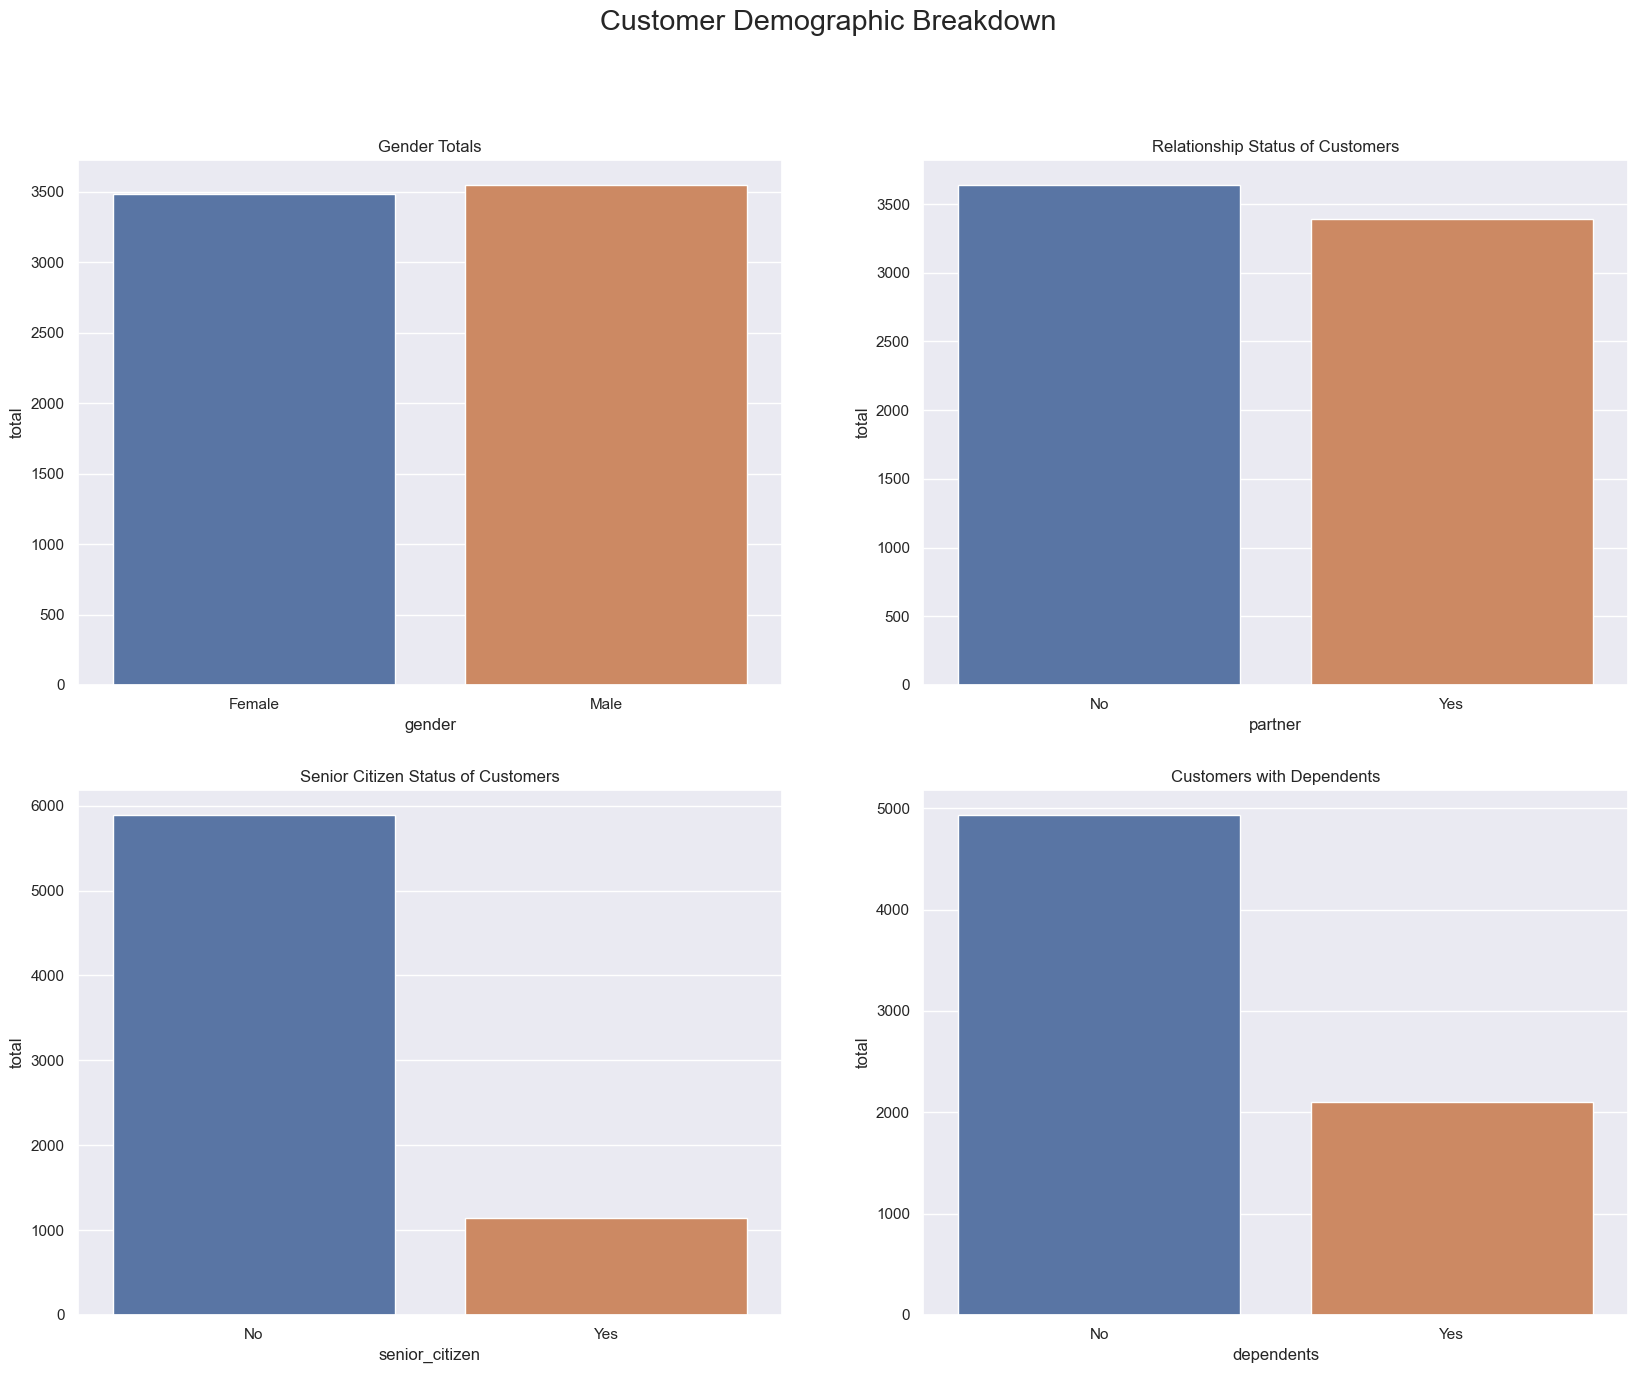

In [188]:
# creating graphical breakdown of demographic trends

fig1, axes = plt.subplots(2, 2, figsize = (20, 15))
fig1.suptitle('Customer Demographic Breakdown', fontsize = 'xx-large')

gender = df_full.groupby('gender').agg({'gender': 'count'}).rename(columns = {'gender': 'total'})
sns.barplot(gender, x = gender.index, y = 'total',ax = axes[0][0])
axes[0][0].set_title('Gender Totals')
        
s_citizen = df_full.groupby('senior_citizen').agg({'senior_citizen': 'count'}).rename(columns = {'senior_citizen': 'total'})
sns.barplot(s_citizen, x = s_citizen.index, y = 'total', ax = axes[1][0])
axes[1][0].set_title('Senior Citizen Status of Customers')


relation = df_full.groupby('partner').agg({'partner': 'count'}).rename(columns = {'partner': 'total'})
sns.barplot(relation, x = relation.index, y = 'total', ax = axes[0][1])
axes[0][1].set_title('Relationship Status of Customers')


dependents = df_full.groupby('dependents').agg({'dependents': 'count'}).rename(columns = {'dependents': 'total'})
sns.barplot(dependents, x = dependents.index, y = 'total', ax = axes[1][1])
axes[1][1].set_title('Customers with Dependents')




From the above charts, we can gather the following insights:

    - there is a balanced total of males and females in our customer base 
    - there are a relatively balanced amount of customers with dependents and without 
    - a majority of our customer base are NOT senior citizens
    - the number of customers with dependents is approx. half of the total without dependents

Text(0.5, 1.0, 'Customer Retention Totals')

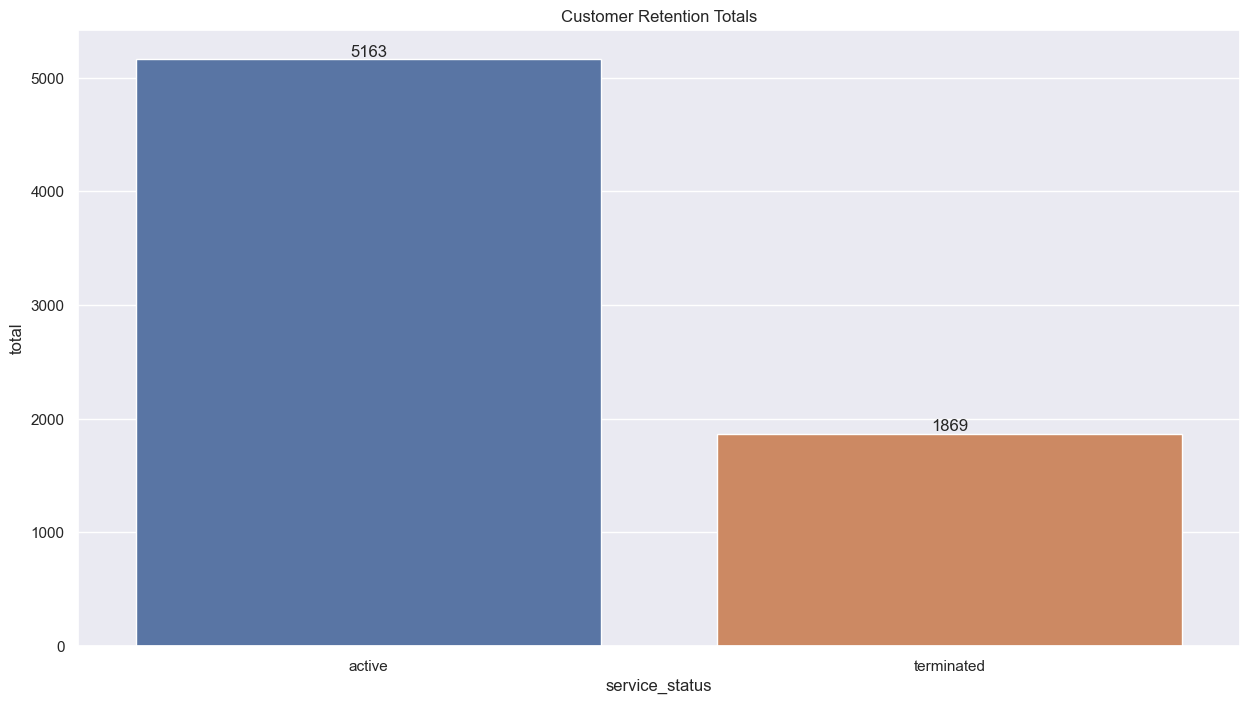

In [191]:
# visualizing custmomers who have stayed versus left the service 

departed_totals = df_full.groupby('service_status').agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'})
ax = sns.barplot(departed_totals, y = 'total', x = departed_totals.index )
ax.bar_label(ax.containers[0])
ax.set_title('Customer Retention Totals')

This gives rise to a few questions I would like to explore in my bivariate analysis: 

    - Of the totals of those in each payment method preference, what is the segmentation of plan preference? 
    - What is the relationship between total monthly charges and total charges? 
    

Text(0.5, 1.0, 'New Customers Month Over Month')

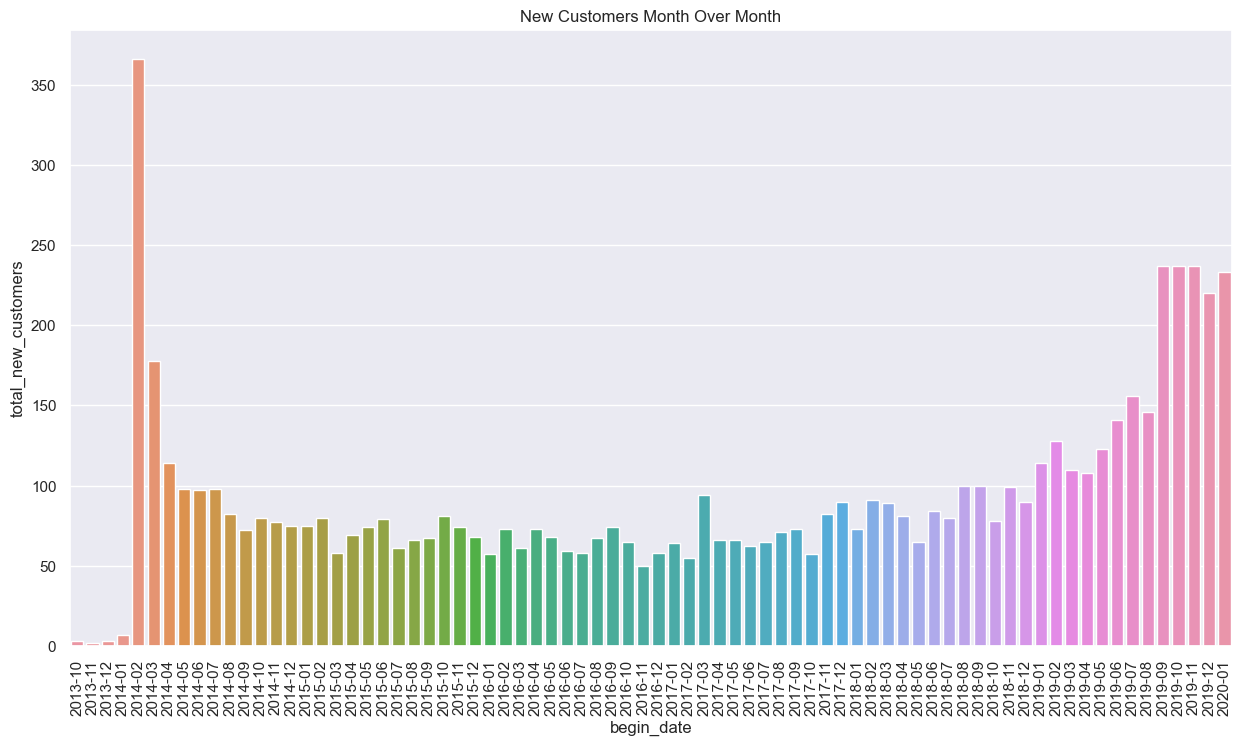

In [192]:
new_customers = df_full.groupby('begin_date').agg({'begin_date': 'count'}).rename(columns = {'begin_date': 'total_new_customers'})
  


new_customers.index = new_customers.index.strftime('%Y-%m')
sns.barplot(new_customers, x = new_customers.index, y = 'total_new_customers').tick_params(axis='x', rotation=90)
sns.set(rc={'figure.figsize':(15,8)})
ax = plt.gca()
ax.set_title("New Customers Month Over Month")






                                                               

Looking at the new customer additions month over month, we see a very large spike in early 2014, which then trends down, stabilizing unitl another spike toward the end of 2019 into the beginning of 2020.

## Multivariate Analysis

Text(0.5, 1.0, 'Total Charges vs Monthly Charges')

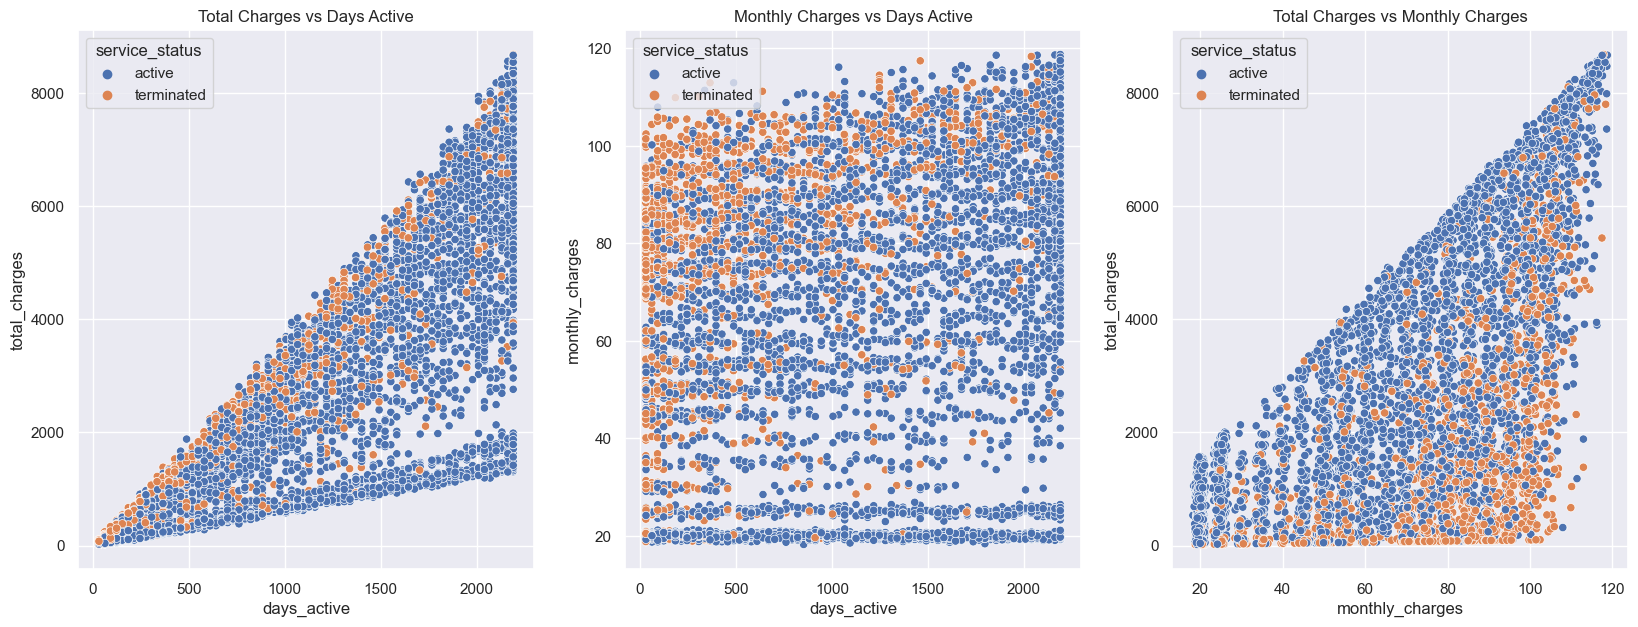

In [193]:
#  creating a scatter plot of the monthly charges and total charges columns 

fig2, axes = plt.subplots(1, 3, figsize = (20, 7))
                          
sns.scatterplot(df_full, y = 'total_charges', x = 'days_active', hue = 'service_status', ax = axes[0])
axes[0].set_title('Total Charges vs Days Active')

sns.scatterplot(df_full, y = 'monthly_charges', x = 'days_active', hue = 'service_status', ax = axes[1])
axes[1].set_title('Monthly Charges vs Days Active')

sns.scatterplot(df_full, y = 'total_charges', x = 'monthly_charges', hue = 'service_status', ax = axes[2])
axes[2].set_title('Total Charges vs Monthly Charges')

Looking at the above scatterplots, there is no clear segmentation between those who have left the service and those that are not; however, there is a trend emerging here. Though the departed customers are scattered throughout, there seems to be some clustering in certain areas:

    -In the 'Total Charges vs Days Active' graph, we see departed customers densly occupying the highest the 'cieling' of the linear line. This top of this line represents a price ceiling for how much a customer can be paying given how long they have been a part of the service. This could indicate that many of those who are leaving are paying the most they possibly can in proprtion to how long they have been a customer to Telecom. This would indicate high monthly charges. 
    
    - This brings us to 'Monthly Charges vs Days Active' graph, where we see a similar theme depictyed. Though the departed customers are scattered throughout, we seen see a high density of those who spent few than 500 days with Telecom AND departed paying near the top echelon of monthly charges. Perhaps these are folks who are signing up for expensive packages as soon as they join. 
    
    - Which brings us to our 'Total Charges vs Monthly Charges'. Here we see a significant density in an area that signals high monthly charges with low total charges relevant to the rest of the customer base. This shows a trend emerging, many customers who sign up and buying expensive packages right away are at risk of departing the service soon after.

Text(0.5, 1.0, 'Subscription Type Preference for Customers Who Stayed vs Departed')

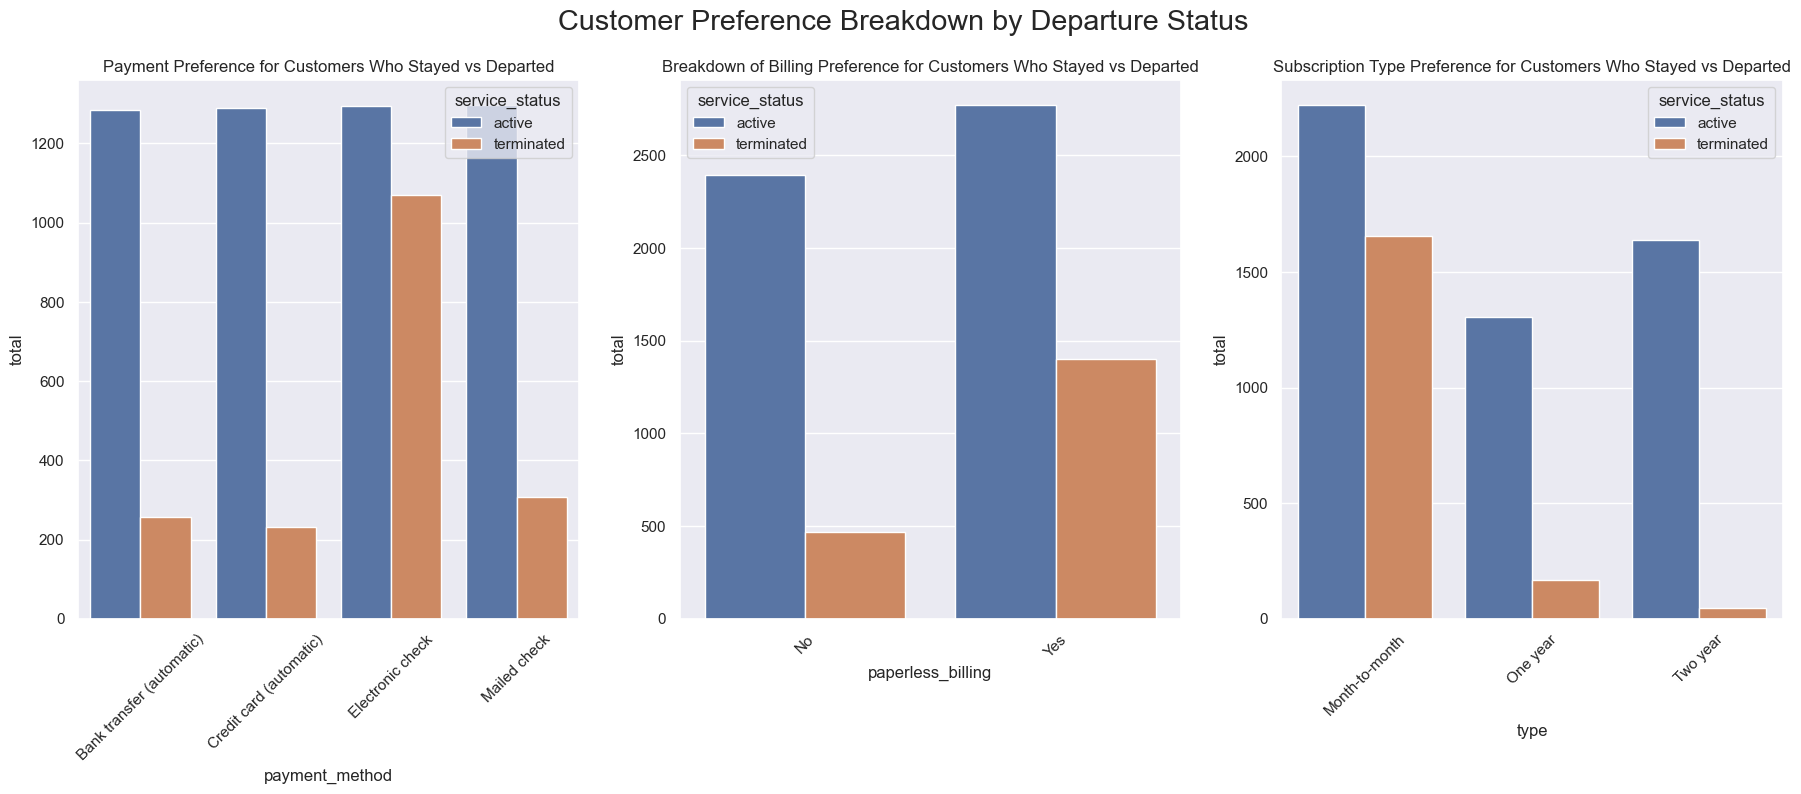

In [197]:
fig, axes = plt.subplots(1, 3, figsize = [22, 7])
fig.suptitle('Customer Preference Breakdown by Departure Status', fontsize = 'xx-large')


pay_split = df_full.groupby(['payment_method', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(pay_split, x = 'payment_method', y = 'total', hue = 'service_status', ax = axes[0]).tick_params(axis='x', rotation=45)
axes[0].set_title('Payment Preference for Customers Who Stayed vs Departed')

paper_split = df_full.groupby(['paperless_billing', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(paper_split, x = 'paperless_billing', y = 'total', hue = 'service_status', ax = axes[1]).tick_params(axis='x', rotation=45)
axes[1].set_title('Breakdown of Billing Preference for Customers Who Stayed vs Departed')


type_split = df_full.groupby(['type', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(type_split, x = 'type', y = 'total', hue = 'service_status', ax = axes[2]).tick_params(axis='x', rotation=45)
axes[2].set_title('Subscription Type Preference for Customers Who Stayed vs Departed')

We can also see here that the majority of those who have left have preferred to pay with an e-check versus any other form of payment, preferred paperless billing, and the month-to-month service plan. 

Text(0.5, 1.0, 'Customers Who Stay vs Depart By Dependents Status')

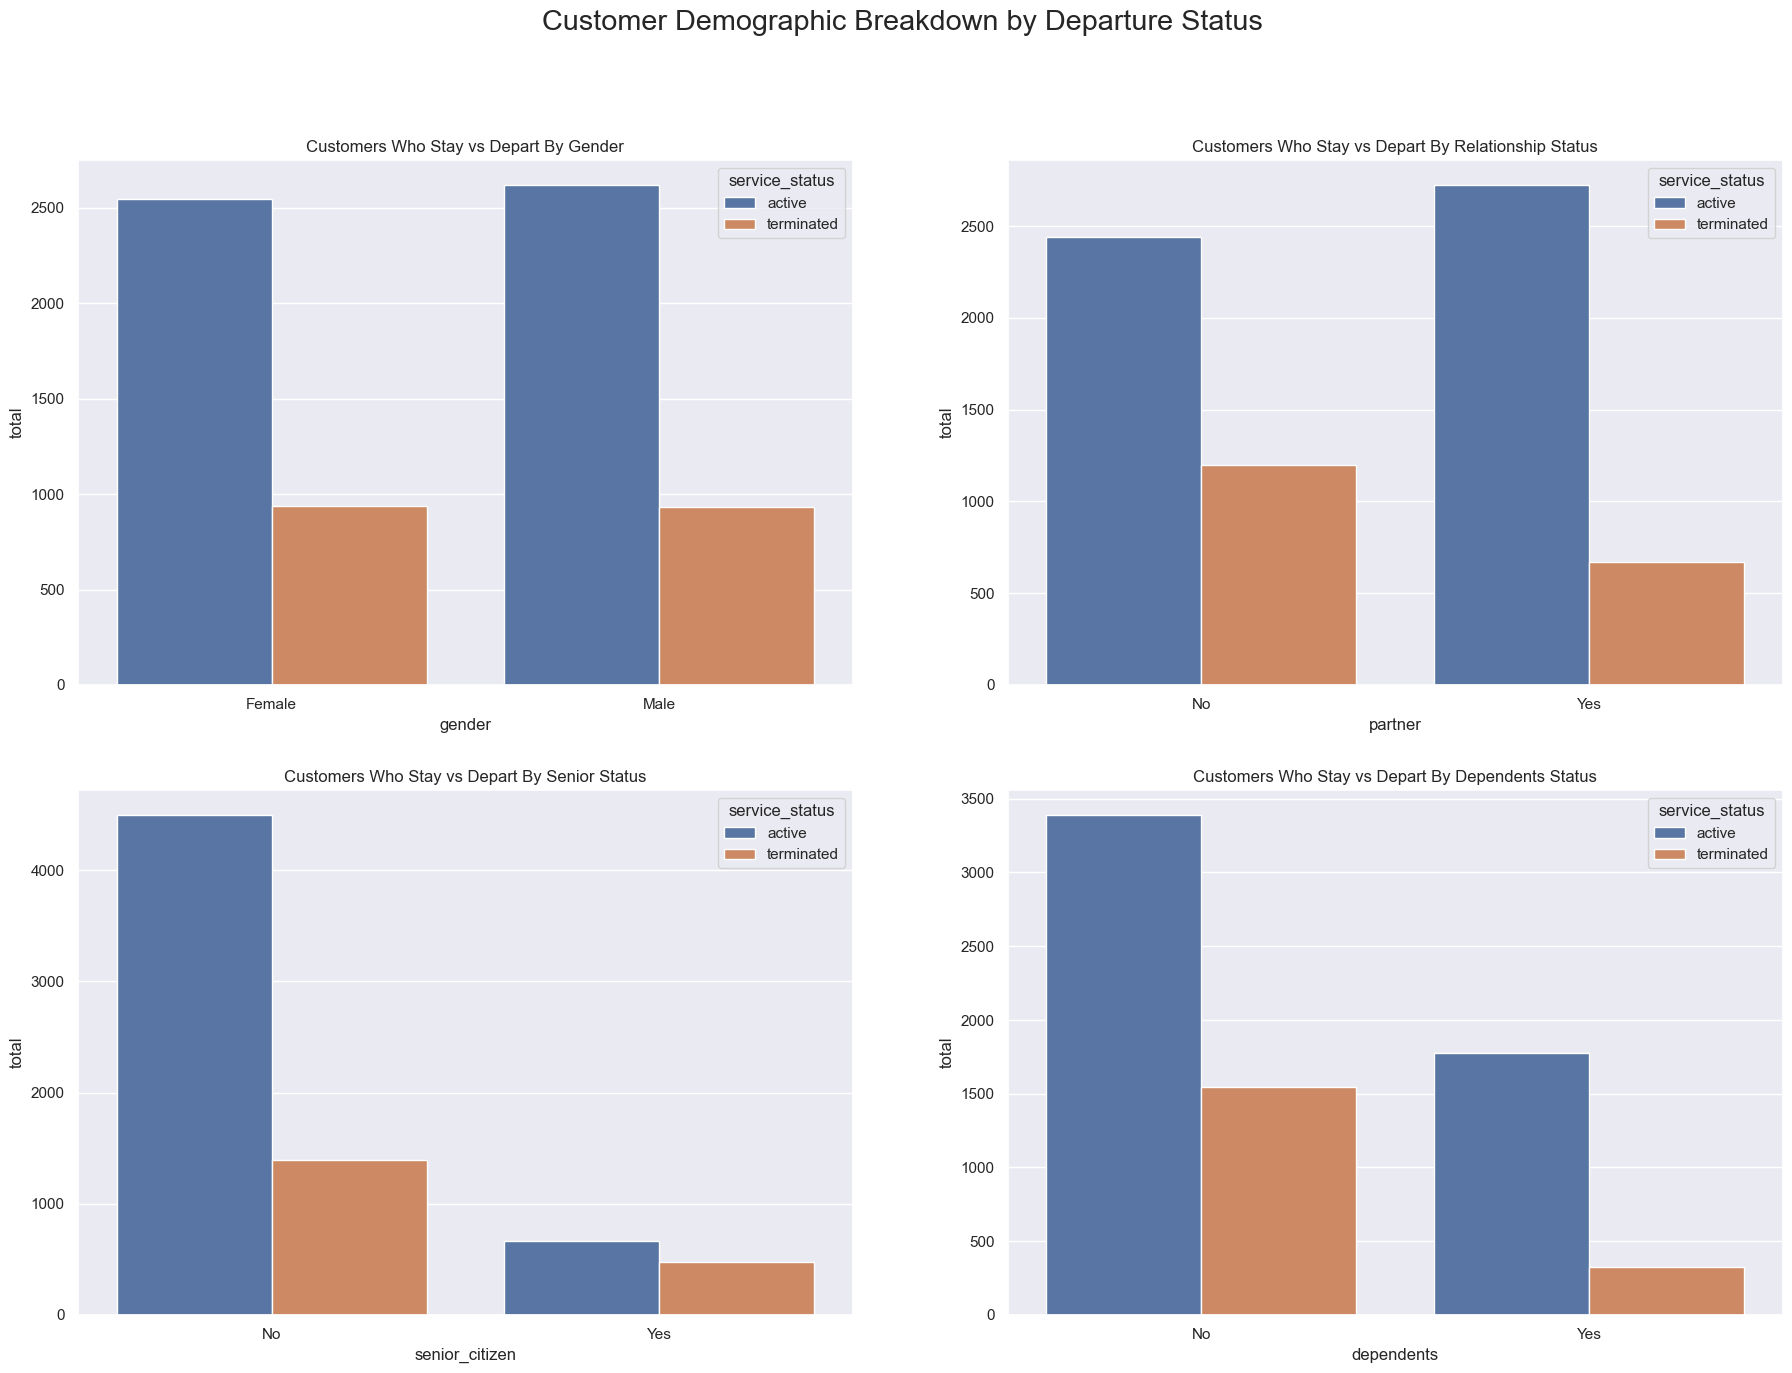

In [199]:


fig, axes = plt.subplots(2, 2, figsize = [22, 15])
fig.suptitle('Customer Demographic Breakdown by Departure Status', fontsize = 'xx-large')

gender_split = df_full.groupby(['gender', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(gender_split, x = 'gender', y = 'total', hue = 'service_status', ax = axes[0][0])
axes[0][0].set_title('Customers Who Stay vs Depart By Gender')

senior_split = df_full.groupby(['senior_citizen', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(senior_split, x = 'senior_citizen', y = 'total', hue = 'service_status', ax = axes[1][0])
axes[1][0].set_title('Customers Who Stay vs Depart By Senior Status')

relation_split = df_full.groupby(['partner', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(relation_split, x = 'partner', y = 'total', hue = 'service_status', ax = axes[0][1])
axes[0][1].set_title('Customers Who Stay vs Depart By Relationship Status')

dependents_split = df_full.groupby(['dependents', 'service_status']).agg({'service_status': 'count'}).rename(columns = {'service_status': 'total'}).reset_index()
sns.barplot(dependents_split, x = 'dependents', y = 'total', hue = 'service_status', ax = axes[1][1])
axes[1][1].set_title('Customers Who Stay vs Depart By Dependents Status')


Based on the above graphs, I noticed the following: 

    - there is no major indicators that gender influenced the decision to leave or stay with Telecom
    - single people tend to leave more than those in a partnership 
    - though senior citizens make up a small total of the customer base, their willingness to stay versus leave is quite balanced
    - customers without dependents are more likely to leave than those with dependents

# 3 Feature Splitting and Engineering <a id = 'features'></a>

In [200]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Checklist:

    - extract datetimes out into the data set by month and year ✅
    - drop useless columns like begin date, end date, and customer id ✅
    - upsample those that have left the service ✅
    - establish target and feature column ✅
    - one hot encode ✅
    - standardize numerical values 
    - split data into test and train/validation - will be using CV techniques, so no need to split into validation as well 

In [207]:
# creating datetime features by extracting individual datetime objects 
data = df_full.copy()
data['year'] = df_full['begin_date'].dt.year 
data['month'] = df_full['begin_date'].dt.month 


In [208]:
#  changing target value to 1/0s for feature/target preparation
data['departed'] = [1 if i == 'terminated' else 0 for i in data['service_status']]

# dropping columns that are not needed in our model 
data.drop(['customer_id', 'begin_date', 'end_date', 'service_status', 'days_active'], axis = 1, inplace = True)

In [212]:
# encoding data
data_ohe = pd.get_dummies(data, drop_first = True)

In [213]:
# creating features and target variables

features = data_ohe.drop('departed', axis = 1)
target = data_ohe['departed']

In [214]:
# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = .25,
                                                    random_state = 24321)


Need to ensure that the features in the test set are correctly scaled before moving on to final testing; for now, I can still create the dummy model and the rest of the model with the random CV method. 

# Model Creation and Evaluation <a id = 'model'><a/> 

In [215]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.tree import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import *
from lightgbm import * 
from sklearn.dummy import DummyClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler


In [216]:
# establishing dummy model using uniform values
y_pred_constant = pd.Series(1, index = y_train.index)

roc_score= roc_auc_score(y_train, y_pred_constant)
f1 = f1_score(y_train, y_pred_constant)
accuracy = accuracy_score(y_train, y_pred_constant)

print(f'Roc Auc - Baseline Model: {roc_score*100:.2f}%')
print(f'F1 score - Baseline Model: {f1*100:.2f}%')
print(f'Accuracy score for Dummy Model: {accuracy*100:.2f}%')

Roc Auc score for Dummy Model: 50.00%
F1 score for Dummy Model: 41.81%
Accuracy score for Dummy Model: 26.43%


In [217]:
# initializing oversampling and scaler for cross validation 
over = RandomOverSampler()
scaler = StandardScaler()

In [218]:
# training Logistic Regression Model

log_model = LogisticRegression(random_state =12345)

# establishing step parameters to feed to pipeline
steps =[('over', over), ('standardscaler', scaler), ('log', log_model)]
pipeline = Pipeline(steps = steps)

# creating cross validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# establishing scoring methods
scorers = {'AUC': 'roc_auc',
           'F1': 'f1',
           'Accuracy': 'balanced_accuracy'}


scores = cross_validate(pipeline,
                        X_train,
                        y_train,
                        cv = cv,
                        scoring = scorers)



roc_score = scores['test_AUC'].mean()
f1 = scores['test_F1'].mean()
accuracy = scores['test_Accuracy'].mean()

print('Logistic Regression Score:')
print(f'Best Roc-Auc Score: {roc_score * 100:.2f}%')
print(f'Best F1 Score: {f1 * 100:.2f}%')
print(f'Best Accuracy Score: {accuracy * 100:.2f}%')


Logistic Regression Score:
Best Roc-Auc Score: 83.75%
Best F1 Score: 62.17%
Best Accuracy Score: 75.95%


In [219]:
# random forest model 

rf = RandomForestClassifier(random_state = 61523)

# establishing step parameters for pipeline
steps =[('over', over),('standardscaler', scaler), ('rf', rf)]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# establishing parameters for random search cross validation
params = {
    'rf__n_estimators': sp_randint(10, 100),
    'rf__max_depth': sp_randint(5, 20),
    'rf__min_samples_split': sp_randint(2, 5),
    'rf__max_leaf_nodes': sp_randint(2, 4)
}

# initializing scoring methods
scorers = {'AUC': 'roc_auc',
           'F1': 'f1',
           'Accuracy': 'balanced_accuracy'}



random_search = RandomizedSearchCV(pipeline,
                                   param_distributions = params,
                                   cv = cv,
                                   n_iter = 10,
                                   scoring = scorers,
                                  refit = 'AUC')

random_search.fit(X_train, y_train)

print('Random Forest Best Parameters and Scores:')
print(f'Best Params: {random_search.best_params_}')
print(f'Best Roc-Auc: {random_search.best_score_*100:.2f}%')

f1 = random_search.cv_results_['mean_test_F1'].mean()
accuracy = random_search.cv_results_['mean_test_Accuracy'].mean()
      
print(f'Mean F1 Scores across all iterations: {f1 *100:.2f}%')
print(f'Mean Accuracy Scores across all iterations: {accuracy *100:.2f}%')

Random Forest Best Parameters and Scores:
Best Params: {'rf__max_depth': 10, 'rf__max_leaf_nodes': 3, 'rf__min_samples_split': 4, 'rf__n_estimators': 88}
Best Roc-Auc: 82.33%
Mean F1 Scores across all iterations: 56.56%
Mean Accuracy Scores across all iterations: 71.79%


In [223]:
# decision tree model

tree_model = DecisionTreeClassifier(random_state = 13234)

steps =[('over', over),('standardscaler', scaler), ('tree', tree_model)]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

params = {
    'tree__max_depth': sp_randint(2,20),
    'tree__min_samples_split': sp_randint(2,5),
    'tree__min_samples_leaf': sp_randint(1,5)
}

scorers = {'AUC': 'roc_auc',
           'F1': 'f1',
           'Accuracy': 'balanced_accuracy'}

random_search = RandomizedSearchCV(pipeline,
                                   param_distributions = params,
                                   cv = cv,
                                   n_iter = 10,
                                   scoring = scorers,
                                  refit = 'AUC')

random_search.fit(X_train, y_train)

print('Decision Tree Best Parameters and Scores:')
print(f'Best Params: {random_search.best_params_}')
print(f'Best Roc-Auc: {random_search.best_score_*100:.2f}%')

f1 = random_search.cv_results_['mean_test_F1'].mean()
accuracy = random_search.cv_results_['mean_test_Accuracy'].mean()
      
print(f'Mean F1 Scores across all iterations: {f1 *100:.2f}%')
print(f'Mean Accuracy Scores across all iterations: {accuracy *100:.2f}%')



Decision Tree Best Parameters and Scores:
Best Params: {'tree__max_depth': 5, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 3}
Best Roc-Auc: 84.24%
Mean F1 Scores across all iterations: 62.61%
Mean Accuracy Scores across all iterations: 75.97%


In [231]:
gbm = LGBMClassifier(learning_rate = .15, 
                     objective= 'binary', 
                     metric = 'auc',
                     random_state = 13234)

steps =[('over', over),('standardscaler', scaler), ('gbm', gbm)]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)


params = {
    'gbm__max_depth': sp_randint(2,20),
    'gbm__n_estimators': sp_randint(100, 1000),
    'gbm__num_leaves': sp_randint(25, 40)
}

scorers = {'AUC': 'roc_auc',
           'F1': 'f1',
           'Accuracy': 'balanced_accuracy'}
           
random_search = RandomizedSearchCV(pipeline,
                                   param_distributions = params,
                                   cv = cv,
                                   n_iter = 10,
                                   scoring = scorers,
                                  refit = 'AUC')

random_search.fit(X_train, y_train)

print('Light GBM Best Parameters and Scores:')
print(f'Best Params: {random_search.best_params_}')
print(f'Best Roc-Auc: {random_search.best_score_*100:.2f}%')

f1 = random_search.cv_results_['mean_test_F1'].mean()
accuracy = random_search.cv_results_['mean_test_Accuracy'].mean()
      
print(f'Mean F1 Scores across all iterations: {f1 *100:.2f}%')
print(f'Mean Accuracy Scores across all iterations: {accuracy *100:.2f}%')


Light GBM Best Parameters and Scores:
Best Params: {'gbm__max_depth': 8, 'gbm__n_estimators': 385, 'gbm__num_leaves': 36}
Best Roc-Auc: 91.64%
Mean F1 Scores across all iterations: 74.68%
Mean Accuracy Scores across all iterations: 82.15%


Based on the above scores, I chose to move forward with the LightGBM model as the final model with the following parameters: 

    - max_depth: 8
    - n_estimators: 385
    - num_leaves: 36
    - learning rate: .15

# Final Model Evaluation <a id = 'final'></a>

In [233]:
# scaling numerical variables
numeric = ['monthly_charges', 'total_charges', 'year', 'month']

scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])


In [234]:
X_over, y_over = over.fit_resample(X_train, y_train)

In [235]:
y_over.value_counts()

1    3880
0    3880
Name: departed, dtype: int64

In [236]:
final_model = LGBMClassifier(learning_rate = .15, 
                            max_depth = 8, 
                            n_estimators = 385,
                            num_leaves = 36,
                            random_state = 24246)

final_model.fit(X_over, y_over)

predictions_test = final_model.predict(X_test)
probabilities_valid = final_model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]





final_auc = roc_auc_score(y_test, probabilities_one_valid)
final_f1 = f1_score(y_test, predictions_test)
final_accuracy = accuracy_score(y_test, predictions_test)

print(f"Roc-Auc score for Final Model on Test Set: {final_auc* 100:.2f}%")
print(f'F1 score for Final Model on Test Set: {final_f1* 100:.2f}%')
print(f'Accuracy score for Final Model on Test Set: {final_accuracy* 100:.2f}%')
      

Roc-Auc score for Final Model on Test Set: 93.13%
F1 score for Final Model on Test Set: 79.21%
Accuracy score for Final Model on Test Set: 89.19%


The final model performed well enough, achieving a roc-auc score of 93.13%. 



# Report <a id = 'report'></a> 

The objective of this project was to create a ML model that couold accurately predict the risk of a Telecom customer leaving their service. This project began with a plan which covered the most important elements of a thorough data analysis and accurate model creation. 

I. Plan Structure and Adjustments

It was apparent from my first look into the data that it was of good quality. There were few, if any, missing values. No duplicates were to be found, and there were no superfluous features. Cleaning the data was a swift process. The most noticeable "issue" with the data was the imbalanced number of observations of customers who had stayed versus left. I will touch on this later in this report. 

After looking at all of the datasets, I knew that I wanted to perform some method of merging to create one unified dataframe; however, the sets did not all have the same amount of rows. I knew that once merged, this would create a slew of missing values. Ultimately, I filled these missing values with 'None' strings as all of them represented customers who did not have internet or phone data. 

Next, I focused on Exploratory Data Analysis(EDA) where I gathered a concrete understanding of the customer base and their collective behaviors. Over the course of this portion, a pattern amongst those who had left Telecoms service and those who had not. This gave me confidence that a ML model would be effective in delineating between the two groups and predicting future departures. 

From here, I prepared features for model testing, mostly removing superfluous columns that would provide no value to the models. The biggest focus here was to address the imbalance of the classes, that being those who had left the service and those who had stayed. I created a pipeline to upsample the minority class using a random oversampling technique, which I will discuss further when touching on the model selection process. 

Though the loose structure of this plan remained intact throughout the duration of this project, small adjustments became more necessary as I moved through it. I had orginally planned to merge the dataset post-EDA, though as I begun to look through each set, I thought it best to merge before any type of analysis to have everything in one place. Besides this, there were no other major adjustments made to the orginal plan other than some minor restructuring of the order of code blocks. 

II. Difficulties and Adjustments

I mainly faced only one major difficulty during this project. I had originally chosen to upsample the minority class by simply writing a function that would multiply the number of minority class observations by a constant, effectively balancing the two classs. However, in practice, this did not work given my method of hyperparameter tuning during model selection. Upsampling prior to the use of cross validation techniques durin model selection is known to create data leakage, detracting from my ability to attain an accurate metric of model performance. After some counsel and some research, I decdied that it would be best to create a pipeline that would use random oversampling to balance the data. Random Oversampling in a pipeline allows for upsampling occur at each iteration of cross validation, solving the data leakage problem. Random oversampling has been shown to be more effective than SMOTE(Synthetic Minority Oversampling Technique) in classification tasks, which is why I ultimately chose this technique. 

III. Key Steps 

During this project, there were three key steps in attaining the understanding and final model score that I did: multivariate analysis of the target variable, correct upsampling techniques, and the use of the predict_proba() method when attaining an accurate ROC-AUC score for the final model. 

Multivariate analysis of the target variable in relation to other features provided key insights regarding the differing behaviors between customers who left and stayed with Telecom. 

Correct upsampling allowed for me to have an accurate metric on the performance and thus, comparison, of different classification models. As a result, I was confident that the final model I chose was the best configuration for the task. 

Lastly, given the nature of the random search cross-validation method, extracting an accurate ROC-AUC score was quite simple. However, it was pointed out to me that this simply was not the best way to extract an accurate measure for final model performance. Instead of using the roc_auc_score method on predicted classes, it was more accurate to use the predict_proba() method which instead predicts probabilites of class predictions and extracts a ROC-AUC score from those values. This gave me a better understanding of my model's true performance. 

IV. Final Model and Scoring

The final model that I believe would be best for this task is a Light Gradient Boosting Model, otherwise known as LightGBM, with the following hyperparameters:

    - max_depth: 8
    - n_estimators: 385
    - num_leaves: 36
    - learning rate: .15
    
This combination allowed for a final ROC-AUC score of 93.59%, a fantastic quality score. This model is ready for implementation.